In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
def preprocess_metadata(metadata_path):
    idm_df = pd.read_csv(metadata_path)
    idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
    return idm_df_filtered

def match_images_with_metadata(image_files, metadata, is_night=False):
    image_data = []
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        village_code = img_name.split('.')[0] if is_night else img_name.split('-')[0]
        village_info = metadata[metadata['KODE BPS'] == int(village_code)]
        if not village_info.empty:
            kecamatan = village_info['KECAMATAN'].values[0]
            desa = village_info['DESA'].values[0]
            status = village_info['BINARY STATUS'].values[0]
            image_data.append({
                'id': village_code,
                'filename': img_name,
                'filepath': img_path,
                'kecamatan': kecamatan,
                'desa': desa,
                'status': status
            })
    return pd.DataFrame(image_data)

def normalize_path(path):
    return os.path.normpath(path)

def normalize_paths(df, path_column):
    df[path_column] = df[path_column].apply(normalize_path)
    return df

def plot_class_distribution(idm_df_filtered):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='BINARY STATUS', data=idm_df_filtered)
    plt.title('Class Distribution')
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

def show_sample_images(day_image_data, night_image_data, class_label, n=5, cols=2):
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]

    common_villages = pd.merge(class_images_day, class_images_night, on='id')
    sample_villages = common_villages.sample(n)

    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols * 2, figsize=(30, 5 * rows))
    fig.patch.set_facecolor('black')
    axes = axes.flatten()

    for i, (_, village_row) in enumerate(sample_villages.iterrows()):
        # Day images
        img_path_day = village_row['filepath_x']
        img_day = Image.open(img_path_day)
        ax_day = axes[i * 2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {village_row['kecamatan_x']}_{village_row['desa_x']}", color='white')
        ax_day.axis('off')
        ax_day.set_facecolor('black')

        # Night images
        img_path_night = village_row['filepath_y']
        img_night = Image.open(img_path_night)
        ax_night = axes[i * 2 + 1]
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {village_row['kecamatan_y']}_{village_row['desa_y']}",
                           color='white')
        ax_night.axis('off')
        ax_night.set_facecolor('black')

    for ax in axes[len(sample_villages) * 2:]:
        ax.axis('off')
        ax.set_facecolor('black')

    plt.tight_layout()
    plt.show()

def preprocess_image(image_path, target_size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize(target_size)
        img = np.array(img).astype(np.float32) / 255.0
    return img

In [19]:
def load_and_preprocess_data(day_folder, night_folder, target_size=(224, 224)):
    x_day = []
    x_night = []
    y = []

    for class_label, class_folder in enumerate(['TERTINGGAL', 'MAJU']):
        day_class_path = os.path.join(day_folder, class_folder)
        night_class_path = os.path.join(night_folder, class_folder)

        sentinel_images = []
        landsat_images = []
        night_images = []

        for root, _, files in os.walk(day_class_path):
            for file in files:
                if file.endswith('-s.png'):
                    sentinel_images.append(os.path.join(root, file))
                elif file.endswith('-l.png'):
                    landsat_images.append(os.path.join(root, file))

        for root, _, files in os.walk(night_class_path):
            for file in files:
                if file.endswith('.png'):
                    night_images.append(os.path.join(root, file))

        night_image_dict = {os.path.basename(img).replace('.png', ''): img for img in night_images}

        for day_image_path in sentinel_images + landsat_images:
            base_name = os.path.basename(day_image_path).replace('-s.png', '').replace('-l.png', '')
            night_image_path = night_image_dict.get(base_name)

            if night_image_path:
                x_day.append(preprocess_image(day_image_path, target_size))
                x_night.append(preprocess_image(night_image_path, target_size))
                y.append(class_label)  # 0 for 'tertinggal', 1 for 'maju'

    x_day = np.array(x_day)
    x_night = np.array(x_night)
    y = np.array(y)

    return x_day, x_night, y

In [4]:
def load_and_preprocess_data(day_folder, night_folder, target_size=(224, 224)):
    x_day = []
    x_night = []
    y = []

    for class_label, class_folder in enumerate(['TERTINGGAL', 'MAJU']):
        day_class_path = os.path.join(day_folder, class_folder)
        night_class_path = os.path.join(night_folder, class_folder)

        sentinel_images = []
        landsat_images = []
        night_images = []

        for root, _, files in os.walk(day_class_path):
            for file in files:
                if file.endswith('-s.png'):
                    sentinel_images.append(os.path.join(root, file))
                elif file.endswith('-l.png'):
                    landsat_images.append(os.path.join(root, file))

        for root, _, files in os.walk(night_class_path):
            for file in files:
                if file.endswith('.png'):
                    night_images.append(os.path.join(root, file))

        night_image_dict = {os.path.basename(img).replace('.png', ''): img for img in night_images}

        for day_image_path in sentinel_images + landsat_images:
            base_name = os.path.basename(day_image_path).replace('-s.png', '').replace('-l.png', '')
            night_image_path = night_image_dict.get(base_name)

            if night_image_path:
                x_day.append(preprocess_image(day_image_path, target_size))
                x_night.append(preprocess_image(night_image_path, target_size))
                y.append(class_label)  # 0 for 'tertinggal', 1 for 'maju'

    x_day = np.array(x_day)
    x_night = np.array(x_night)
    y = np.array(y)

    return x_day, x_night, y

In [20]:
def create_model(input_shape_day=(224, 224, 3), input_shape_night=(224, 224, 3)):
    # Day input branch
    input_day = Input(shape=input_shape_day, name='day_input')
    x1 = Conv2D(32, (3, 3), activation='relu')(input_day)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Night input branch
    input_night = Input(shape=input_shape_night, name='night_input')
    x2 = Conv2D(32, (3, 3), activation='relu')(input_night)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Concatenate the outputs of the two branches
    combined = concatenate([x1, x2])

    # Fully connected layers
    x = Dense(128, activation='relu')(combined)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=[input_day, input_night], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [21]:
metadata_path = '/kaggle/input/data-au-2/idm_baru.csv'
modified_day_path = '/kaggle/input/data-au-2/Dataset/Dataset/Daylight'
modified_night_path = '/kaggle/input/data-au-2/Dataset/Dataset/NTL'

In [22]:
idm_df_filtered = preprocess_metadata(metadata_path)
idm_df_filtered

,KODE BPS,KECAMATAN,DESA,BINARY STATUS
0,1111010001,SAWANG,RISEH TUNONG,TERTINGGAL
1,1111010002,SAWANG,GUNCI,TERTINGGAL
2,1111010003,SAWANG,KUBU,TERTINGGAL
3,1111010004,SAWANG,BLANG CUT,TERTINGGAL
4,1111010005,SAWANG,RISEH TEUNGOH,TERTINGGAL
...,...,...,...,...
846,1111041003,GEUREDONG PASE,KRUENG MBANG,TERTINGGAL
847,1111041002,GEUREDONG PASE,PULO MEURIA,TERTINGGAL
848,1111041001,GEUREDONG PASE,SUKA DAMAI,MAJU
849,1111022002,BANDA BARO,ALUE KEURINYAI,MAJU


In [23]:
day_files = [os.path.join(root, file) for root, _, files in os.walk(modified_day_path) for file in files]
night_files = [os.path.join(root, file) for root, _, files in os.walk(modified_night_path) for file in files]
day_images_metadata = match_images_with_metadata(day_files, idm_df_filtered)
night_images_metadata = match_images_with_metadata(night_files, idm_df_filtered, is_night=True)

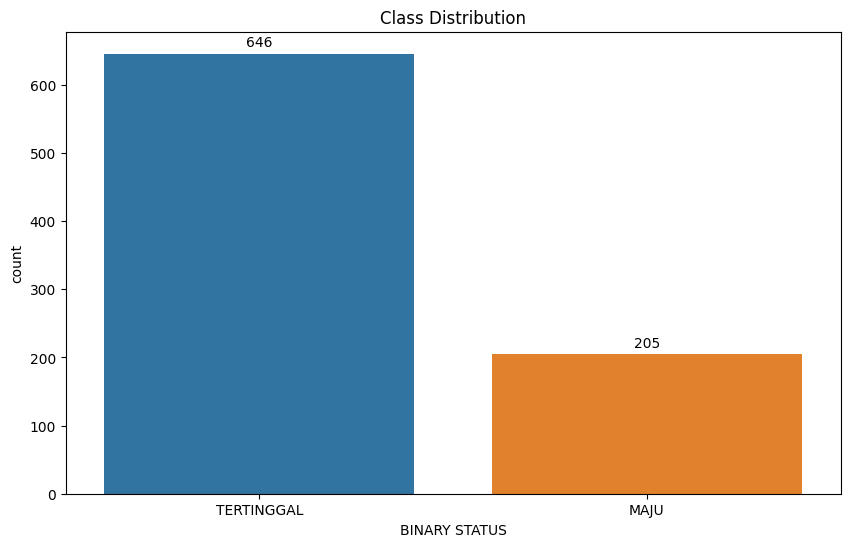

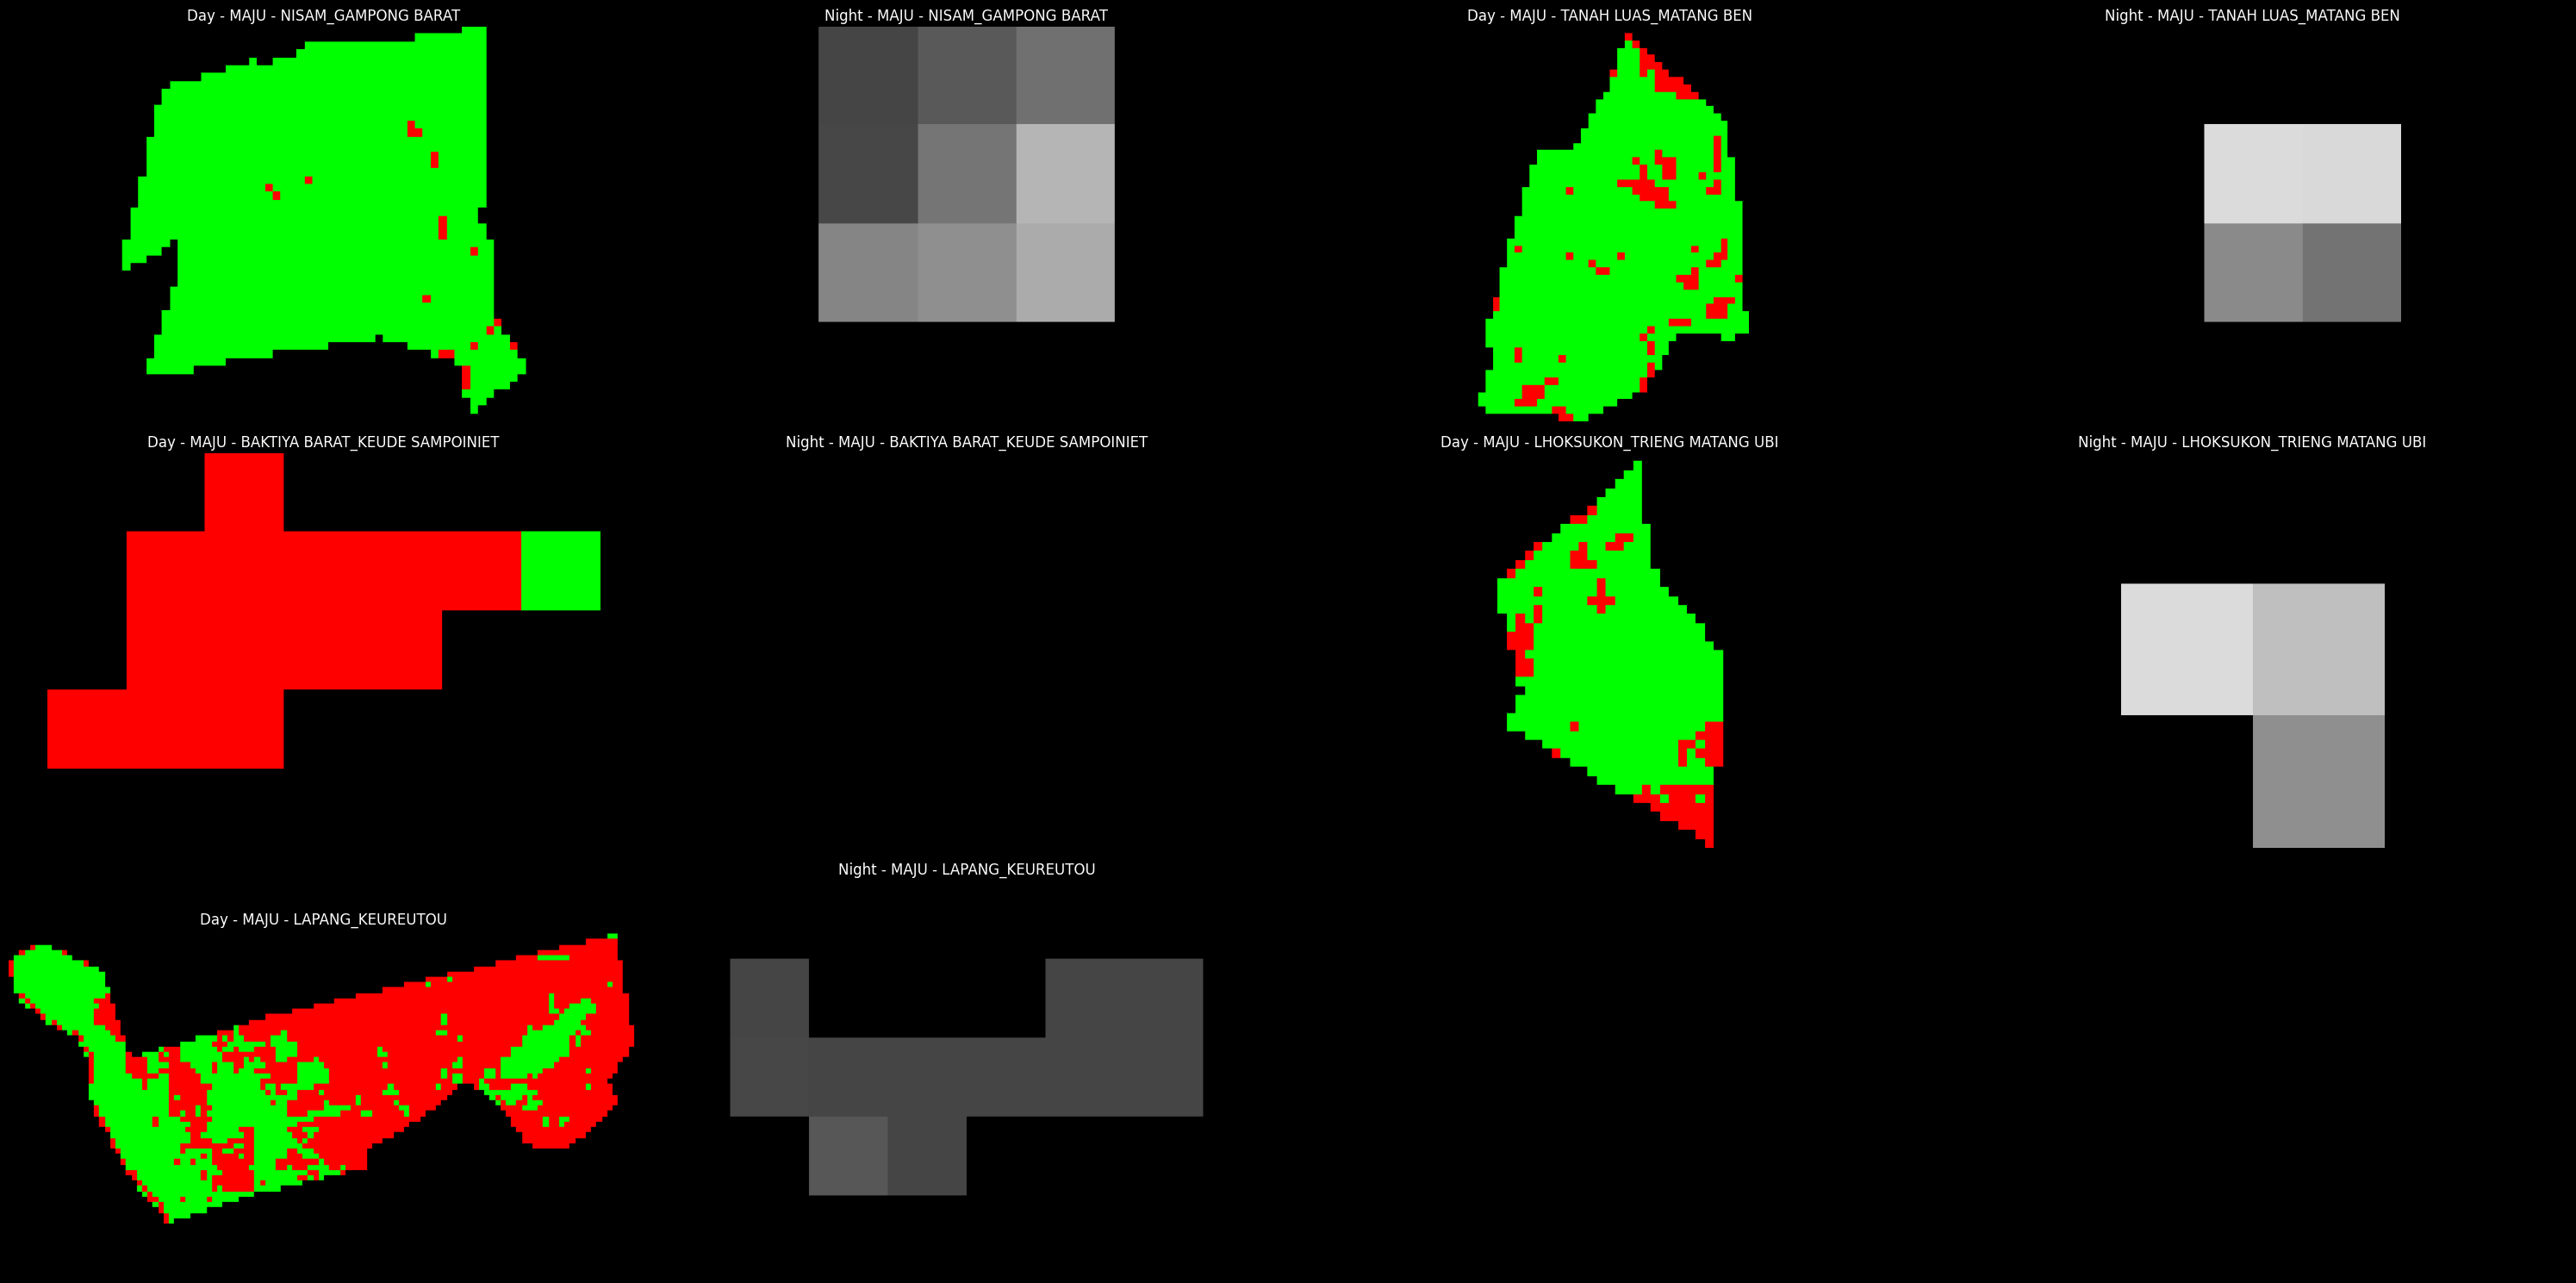

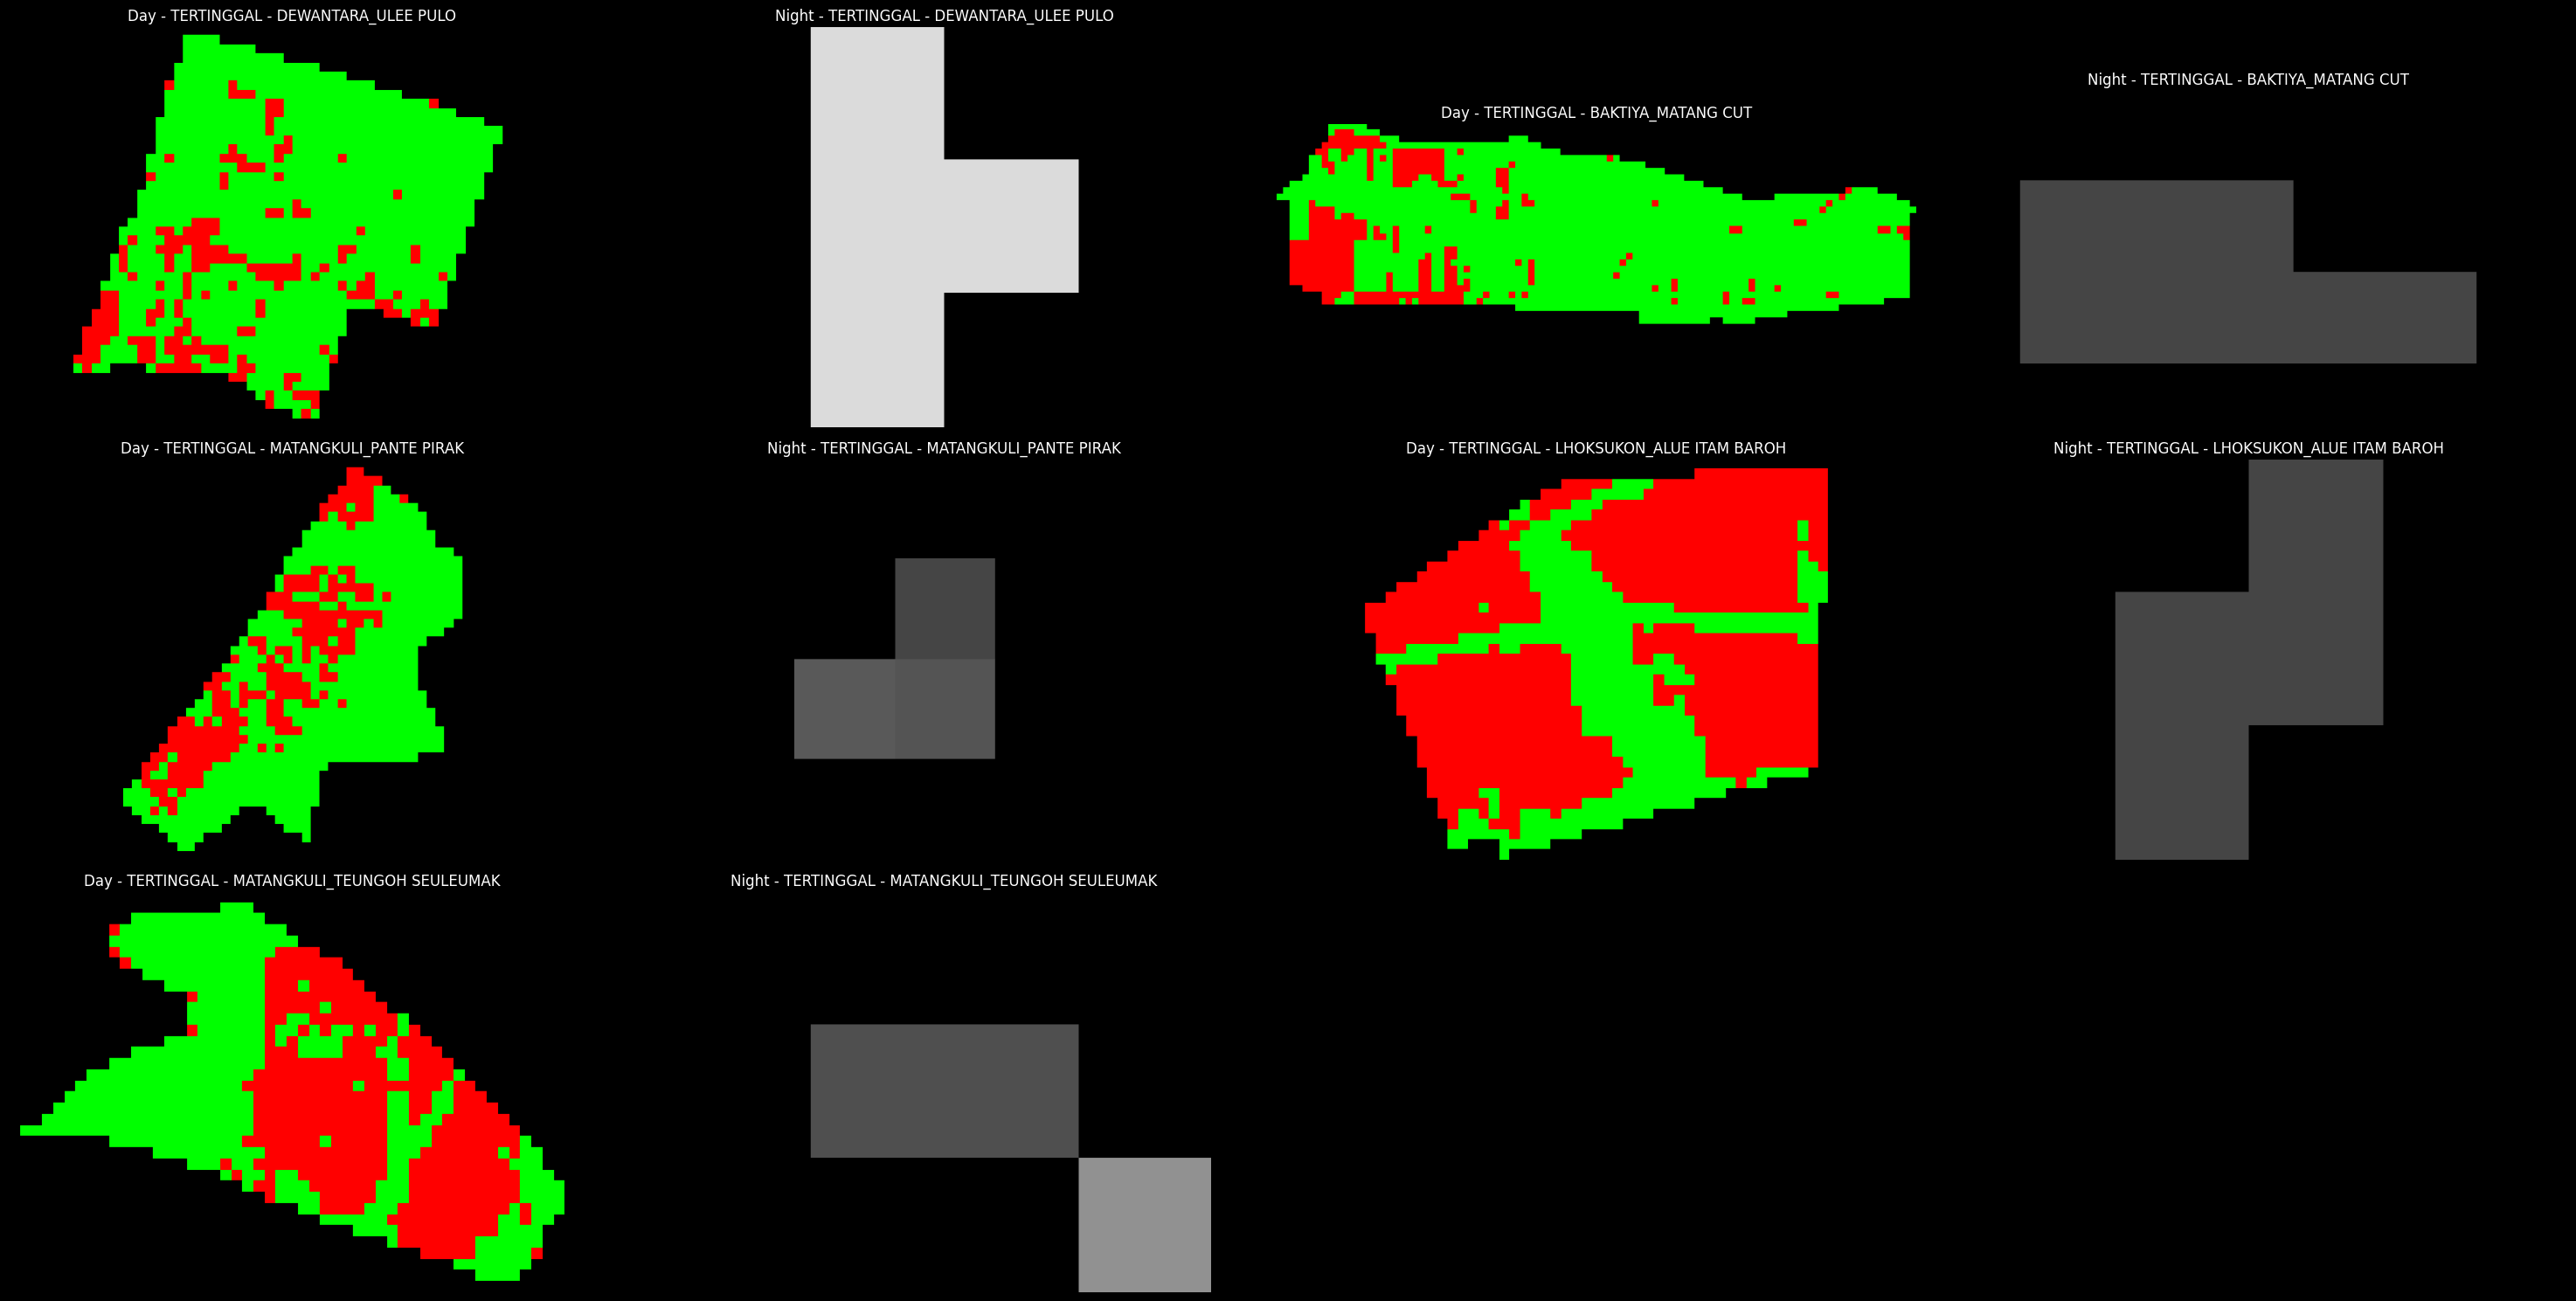

In [24]:
# Visualize data
plot_class_distribution(idm_df_filtered)
show_sample_images(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)

In [25]:
x_day, x_night, y = load_and_preprocess_data(modified_day_path, modified_night_path)

In [26]:
x_day_train, x_day_val, x_night_train, x_night_val, y_train, y_val = train_test_split(
    x_day, x_night, y, test_size=0.3, random_state=42)

In [27]:
# Create model
model = create_model()
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('status_desa_cnn_best2.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ day_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        896 │ day_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 222, 222,  │        896 │ night_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 111, 111,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 54, 54,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 373248)    │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │ 47,775,872 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,822,977 (182.43 MB)

 Trainable params: 47,822,977 (182.43 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Pass the class weights to the fit method
history = model.fit(
    [x_day_train, x_night_train], y_train,
    validation_data=([x_day_val, x_night_val], y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# Save the final model
model.save('status_desa_cnn3.h5')
print("Model saved successfully.")

# Calculate and print balanced accuracy
balanced_acc = calculate_balanced_accuracy(model, [x_day_val, x_night_val], y_val, batch_size=1)
print(f'Balanced Accuracy: {balanced_acc * 100:.2f}%')

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.4846 - loss: 1.9483
Epoch 1: val_accuracy improved from -inf to 0.28180, saving model to status_desa_cnn_best2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4825 - loss: 1.9158 - val_accuracy: 0.2818 - val_loss: 0.7149
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4530 - loss: 0.6414
Epoch 2: val_accuracy improved from 0.28180 to 0.70059, saving model to status_desa_cnn_best2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.4597 - loss: 0.6407 - val_accuracy: 0.7006 - val_loss: 0.6640
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7820 - loss: 0.5088
Epoch 3: val_accuracy improved from 0.70059 to 0.80822, saving model to status_desa_cnn_best2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.7827 - loss: 0.5075 - val_accuracy: 0.8082 - val_loss: 0.4514
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9446 - loss: 0.2456
Epoch 4: v

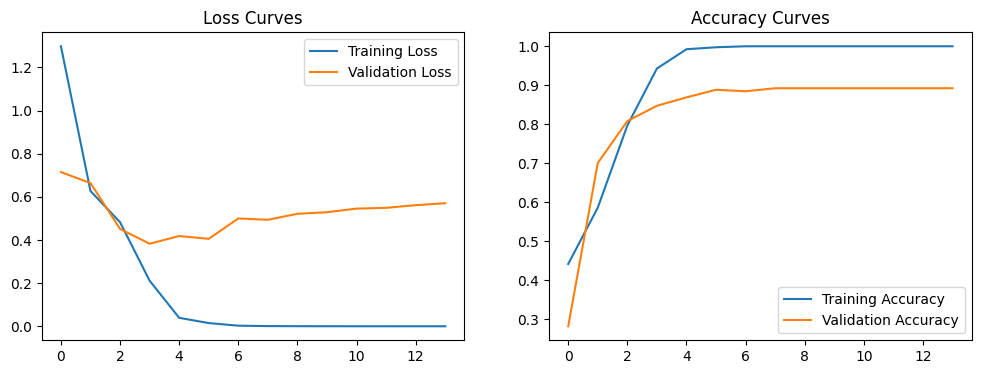

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


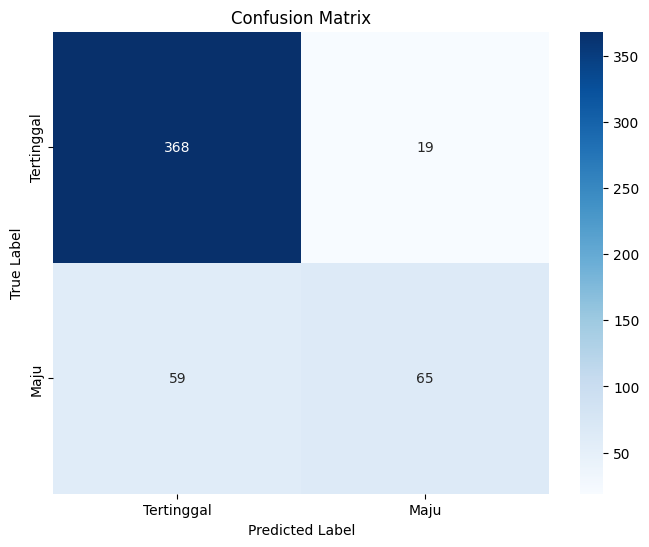

In [34]:
# Assuming `y_true` contains the true labels and `y_pred` contains the predicted labels

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Define class names
class_names = ['Tertinggal', 'Maju']

# Get true and predicted labels
y_true = y_val  # Assuming y_val contains the true labels for the validation set
y_pred = np.round(model.predict([x_day_val, x_night_val])).flatten()

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)


In [33]:
# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report (precision, recall, f1-score for each class)
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate and display individual metrics
balanced_acc, precision, recall, f1 = evaluate_model(model, [x_day_val, x_night_val], y_val, batch_size=1)
print(f'Balanced Accuracy: {balanced_acc * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-score: {f1 * 100:.2f}%')


Accuracy: 84.74%
              precision    recall  f1-score   support

  Tertinggal       0.86      0.95      0.90       387
        Maju       0.77      0.52      0.62       124

    accuracy                           0.85       511
   macro avg       0.82      0.74      0.76       511
weighted avg       0.84      0.85      0.84       511

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Balanced Accuracy: 73.75%
Precision: 77.38%
Recall: 52.42%
F1-score: 62.50%


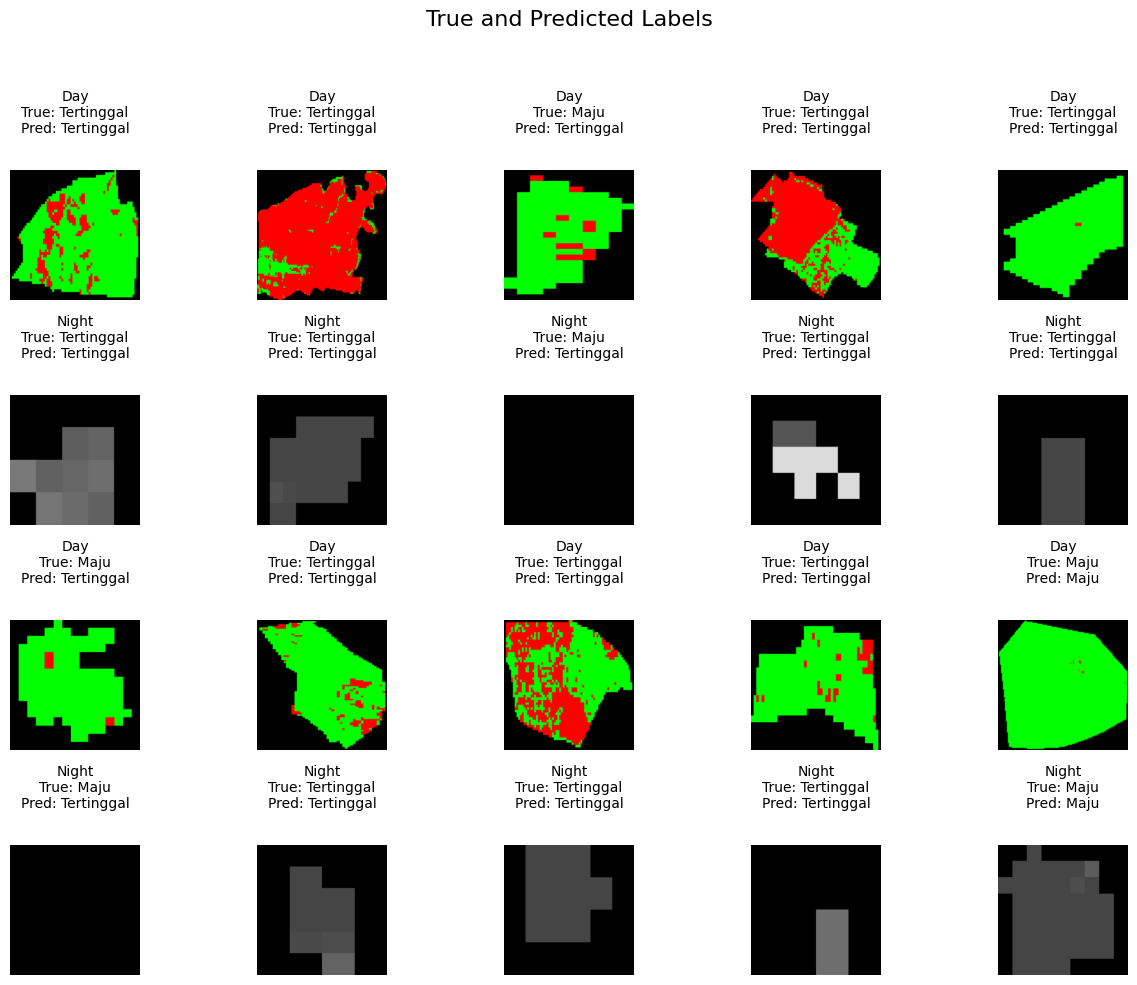

In [32]:
def plot_predictions(x_day, x_night, y_true, y_pred, class_names, n_samples=10):
    rows = 2
    cols = n_samples // 2
    fig, axes = plt.subplots(rows * 2, cols, figsize=(cols * 2.5, rows * 5))
    fig.suptitle('True and Predicted Labels', fontsize=16)
    
    for i in range(n_samples):
        row = (i // cols) * 2
        col = i % cols
        
        ax_day = axes[row, col]
        ax_night = axes[row + 1, col]
        
        ax_day.imshow(x_day[i])
        ax_day.set_title(f'Day\nTrue: {class_names[y_true[i]]}\nPred: {class_names[int(y_pred[i])]}\n', fontsize=10, pad=15)
        ax_day.axis('off')
        
        ax_night.imshow(x_night[i])
        ax_night.set_title(f'Night\nTrue: {class_names[y_true[i]]}\nPred: {class_names[int(y_pred[i])]}\n', fontsize=10, pad=15)
        ax_night.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Asumsikan y_true dan y_pred sudah didefinisikan, dan class_names sudah diberikan
class_names = ['Tertinggal', 'Maju']

# Plot prediksi untuk 10 sampel pertama
plot_predictions(x_day_val[:10], x_night_val[:10], y_true[:10], y_pred[:10], class_names)
